**NOTE:** You probably will see warnings. These are not errors! However, you should read them and try to understand why they're there. Can you fix them?

![](http://rentinginla.com/wp-content/uploads/2015/12/Buying.jpg)
# [Project 2: Predicting House Prices with Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

The goal of this project is for you to use EDA, visualization, data cleaning, preprocesing, and linear models to predict home prices given the features of the home, and interpret your linear models to find out what features add value to a home! This project is a bit more open-ended than project 1. 

Be sure to ...

* Think about your choices when it comes to your choices about the data. Be ready to defend your decisions!
* Use lots of plots to dig deeper into the data! Describe the plots and convey what you learned from them.
* Don't forget to read the [description of the data](../data_description.txt) (also available at the kaggle website)! This has valuable information that will help you clean and impute data. `NaN` means something in many of the columns! Don't just drop or fill them!
* Try fitting many models! Document your work and note what you've tried.
* Apply what you've learned in class, books, videos, Kaggle forums, and blog posts. There have been a TON of blog posts about this;  you should seek them out and read them!


From the Kaggle competition website:

    Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

    With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from IPython.display import display

%matplotlib inline 
np.random.seed(42)

## 1. Load the Data 

* The data comes in three separate CSVs located in `../data/`. 
* Load the CSV into a `DataFrame`. 
* Make sure to check the `.head` or `.sample`. How many rows? How many columns?
* Familiarize yourself with the column names and what they represent.
* Is there a column that can be set as the `index`? If so, set that column as the index when loading the data. (`df.set_index()`)

In [2]:
csv_path = '../data/train.csv'

df = pd.read_csv(csv_path)

**Bonus:** Write an assertion statement to programmatically verify the correct number of rows and columns were imported.

In [3]:
assert len(df.columns) == 81 #79 features, one outcome, plus one ID
assert len(df) == 1460 #looking at the csv directly shows 1461 rows, minus one for the headers

## 2. Exploratory Data Analysis (EDA)

### A. Data Types

Read the data description on Kaggle. Which variables are numerical and categorical? Are there any columns that can be deleted? 

Make sure the `dtype` of each column is correct. 

**NOTE:** There is one column in particular that should be categorical but will load in pandas as numeric.

In [4]:
df.info() # lots of columns with some nulls. Some columns with LOTS of nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# MSSubClass should be categorical
df['MSSubClass'] = df['MSSubClass'].astype(str)

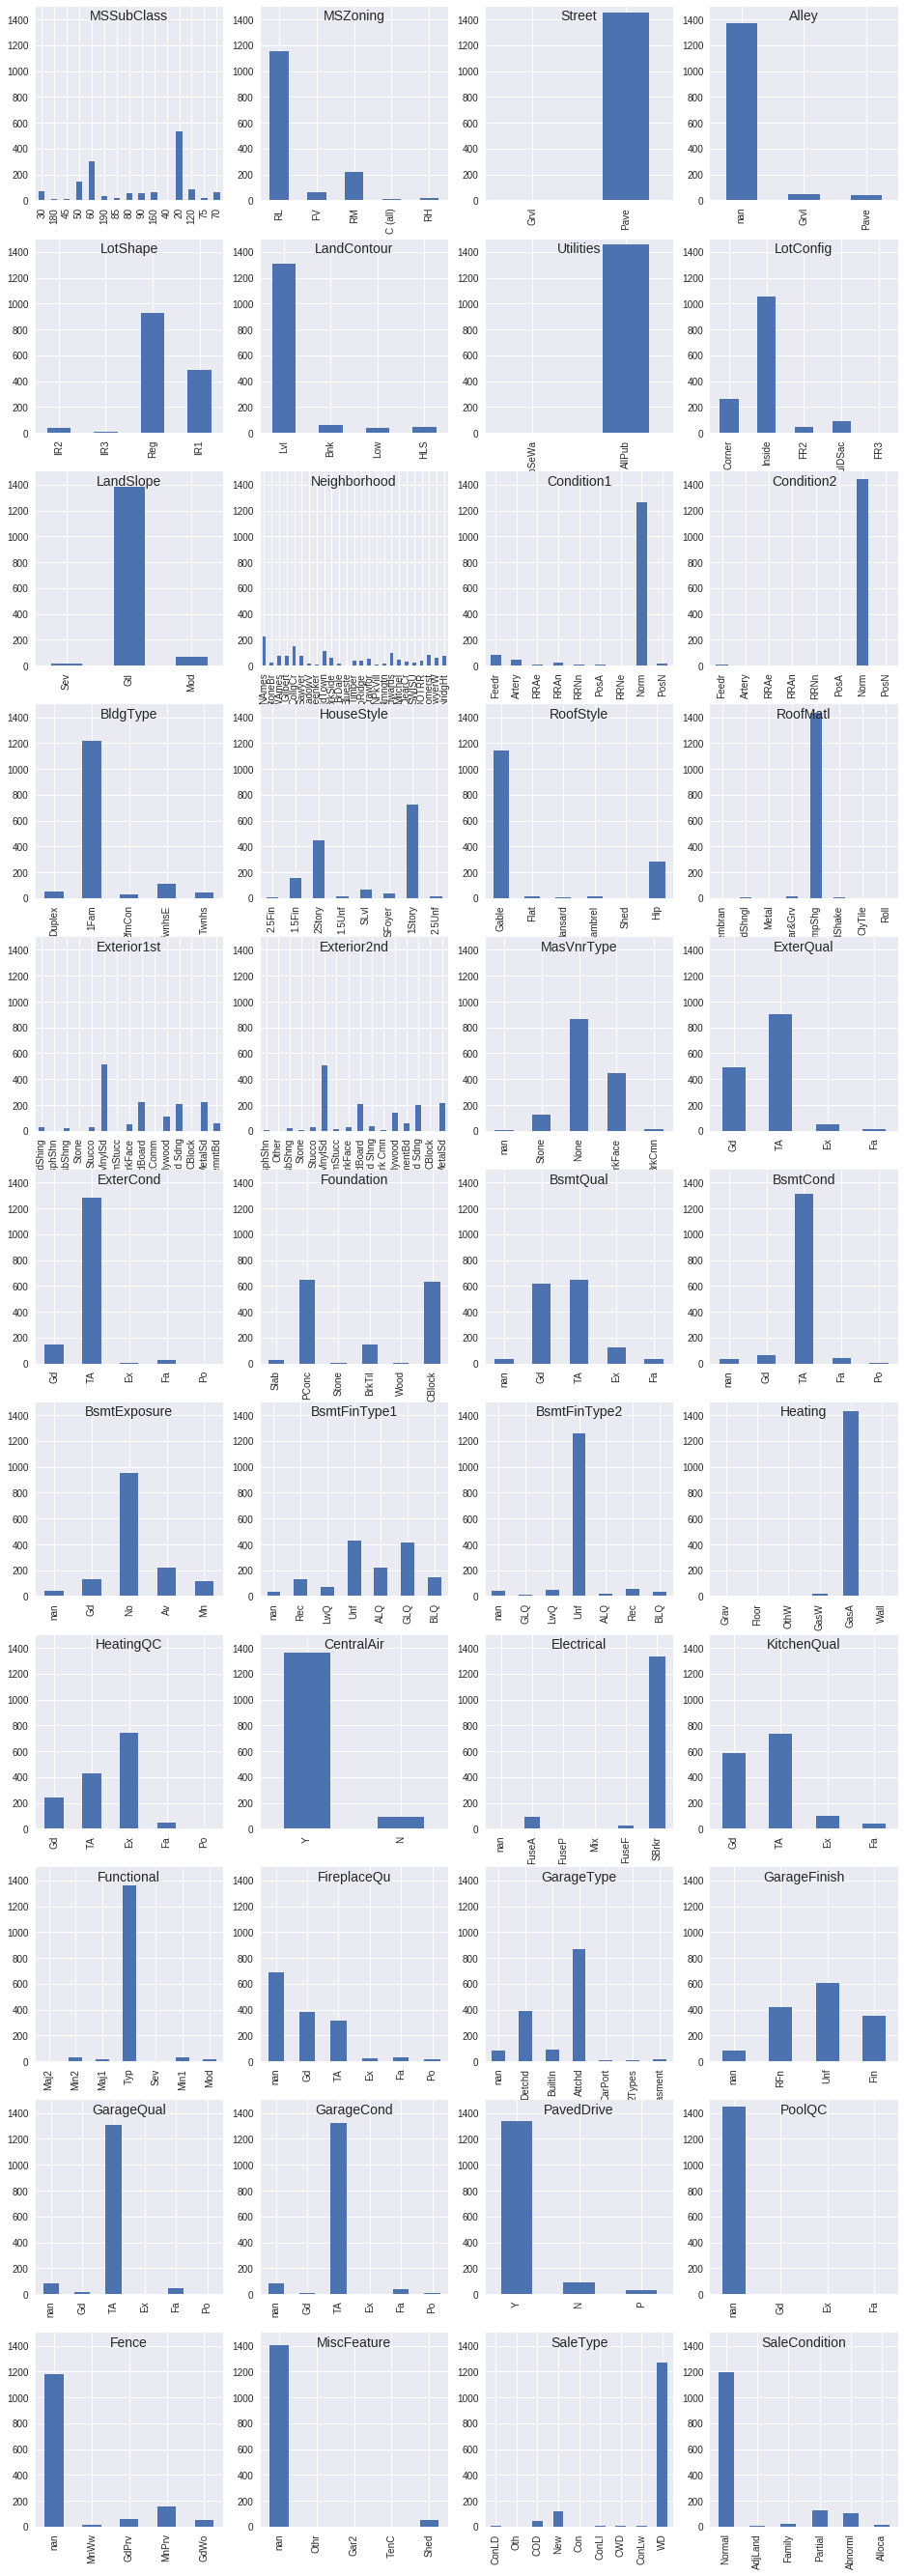

In [6]:
# looking at object variables, including NaN values. Plots are used to give a quick understanding of each var
fig = plt.figure(figsize=(16,48))
for i, col in enumerate(df.select_dtypes(include=['object']).columns):
    fig.add_subplot(11,4,i+1)
    df[col].value_counts(sort = False, dropna = False).plot.bar().set_ylim([0,1500])
    plt.title(col, {'fontsize': 14}, y= .9)
    


## Thoughts on plots above

|Variable|Notes|
| -: | :-------------------------- | 
|MSSubClass|Many categories. Some buckets have very small base sizes, so it will likely need grouping. Maybe group by number of stories  |
|MSZoning|Relatively few categories, but some may need grouping due to small base sizes. Maybe RL vs RM vs Other|
|Street|Very little differentiation; likely exclude from analysis  |
|Alley|Mostly NaNs; possibly exclude or convert to Bool for Alley status  |
|LotShape|Two small categories that may need to be combined together or with a larger group; likely Regular vs Other|
|LandContour|Most lots are level. May need to group non-level   |
|Utilities|Almost exclusively All Public. Likely exclude from analysis   |
|LotConfig|Some very small buckets that may need to be combined; Corner vs Inside vs Other?|
|LandSlope|very little differentiation. Either exclude or transform to Bool for 'Gentle'|
|Neighborhood|Abbreviated neighborhood name. Maybe do some sort of clustering based on prices of houses?|
|Condition1|Will likely need to do some grouping. Norm vs Railroads vs Other?|
|Condition2|Very little differentiation. Likely exclude|
|BldgType|Will needs some grouping; likely Single Family vs Townhouse vs Other|
|HouseStyle|Looks like this may be partially redundant with `MSSubClass`|
|RoofStyle|Some differential, but will need grouping: Gable vs Hip vs Other?|
|RoofMatl|Very little differentiation. Likely exclude or group to CompShg vs other|
|Exterior1st|Lots of differentiation though some groups are too small. Vinyl vs Wood vs Hardboard vs Metal vs Other?|
|Exterior2nd|Same groups as `Exterior1st`?|
|MasVnrType|Some grouping required. None vs Brick vs Other. Should `NaN` be grouped with Other or None?|
|ExterQual|Fair and Typical, Good and Excellent? With two groups, it could be a bool for one group|
|ExterCond|Similare to `ExterQual`|
|Foundation|Group Cinderblock vs Poured Concrete vs Other|
|BsmtQual|Group TA and Fa, Gd and Ex. NaN's likely indicate No basement|
|BsmtCond|Not sure there is enough differentiation to group. Maybe need to test|
|BsmtExposure|Reasonable differentiation; may not need grouping| |
|BsmtFinType1|Reasonable differentiation; may be fine as is, or LwQ and BLQ may need to be grouped|
|BsmtFinType2|Not much differentiation, may need to be grouped (Unf vs Other) or ecluded?|
|Heating|Very little differentiation|
|HeatingQC|May need to group Fa and Po, and maybe with TA. Gd and Ex can be left as is|
|CentralAir|Not much differentiation|
|Electrical|Not much differentiation, may need to group to SBrkr vs Other|
|KitchenQual|May need to group Gd and Ex, TA and Fa|
|Functional|Not much differentiation, may group to Typ vs Other|
|FireplaceQu|May need to group into Gd+Ex, TA+Fa+Po|
|GarageType|Group to Attchd, Detchd vs Other?|
|GarageFinish|Can likely leave as is|
|GarageQual|Not much differentiation and no logical grouping would work. Likely exclude|
|GarageCond|Same as `GarageQual`|
|PavedDrive|Almost no differentiation|
|PoolQC|Almost all `NaN`s, likely exclude|
|Fence|Many `NaN`s; may need to group |
|MiscFeature|Almost all `NaN`s. The Non-`NaN`s are discimilar enough that combining doesn't make sense|
|SaleType|Not much differentiation. Maybe combing to WD vs New vs Other|
|SaleCondition|Could use some groupings, but not sure of predictive merit|

### B. Plot histograms of the numeric columns. 


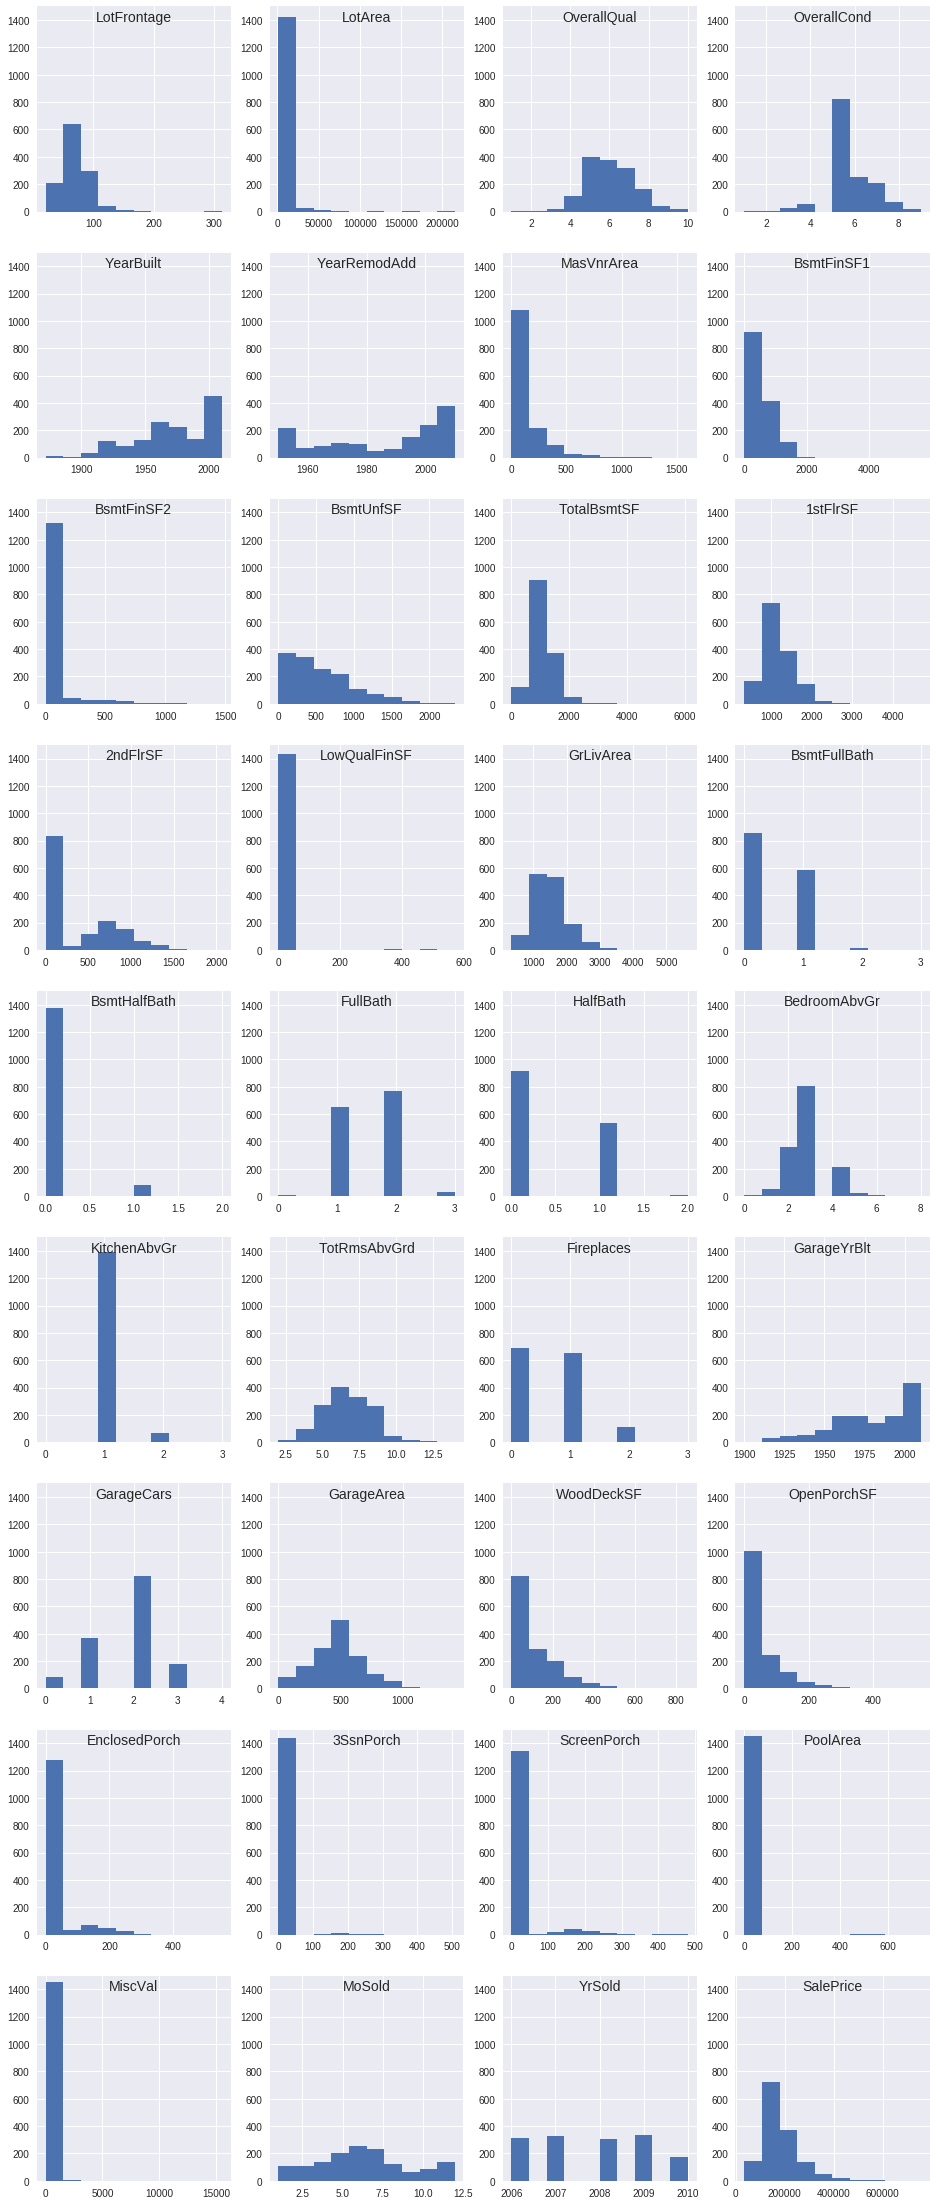

In [7]:
fig = plt.figure(figsize=(16,40))
for i, col in enumerate(df.select_dtypes(include=['int64', 'float64']).columns.drop('Id')):
    fig.add_subplot(9,4,i+1)
    df[col].hist().set_ylim([0,1500])
    plt.title(col, {'fontsize': 14}, y = 0.9)
    
plt.show()

#### What are your observations? Add them to this markdown cell.

---
|Variable|Observations|
| :--- | :--- |
|LotFrontage|may want to cap upper end|
|LotArea|Most valuse are closer to 0|
|OverallQual|A bit right skewed, central tendency toward 5|
|OverallCond|Right skewed, central tendency around 5|
|YearBuilt|Left skewed. Multimodal (likely reflecting building booms) with the heaviest weight in the 2000s|
|YearRemodAdd|Multimodal, weighted towards post 2000|
|BsmtFinSF1|right skewed, heavily weighted towards 0. Not sure if there is enough differentiation to be useful|
|BsmtFinSF2|right skewed, heavily weighted towards 0|
|BsmtUnfSF|right skewed, weighted towards 0 with less extreme weight than `BsmtFinSF` 1 and 2|
|TotalBsmtSF|Likely summation of `BsmtFinSF1`, `BsmtFinSF2`, and `BsmtUnfSF`|
|1stFlrSF|Unimodal, peak around 1000, right skewed|
|2ndFlrSF|bimodal. Many 0s, likely reflecting 1 story houses|
|LowQualFinSF|most values are 0. May not have enough differentiation to be predictive|
|GrLivArea|Unimodal, right skewed, central tendency around 1500|
|BsmtFullBath|Most are 0s. Likely useful though|
|BsmtHalfBath|Almost all 0s. Maybe combine with `BsmtFullBath`, possibly following the 0.5 bath convention, or maybe with `HalfBath`|
|FullBath|Does not include `BsmtFullBath`. Most values are 1 or 2; potentially sum with `BsmtFullBath`|
|HalfBath|Mostly 0s or 1s. Maybe combine with `FullBath` or `BsmtHalfBath`|
|BedroomAbvGr|Almost certainly need to include. May need to bucket 5+|
|KitchenAbvGr|Almost all 1; not sure if it should be included|
|TotRmsAbvGrd|Nice spread. Consider grouping upper bounds|
|Fireplaces|Looks good as is|
|GarageYrBlt|Good range. May need to reverse to create 'age'? Not sure if that would change the outcomes|
|GarageCars|Good range and frequency in each bin. Likely leave as is|
|GarageArea|Vaguely normal looking. May leave as is or rescale?|
|WoodDeckSF|Right skewed. Many 0s|
|OpenPorchSF|Right skewed. Many 0s|
|EnclosedPorch|Almost all 0s, right skewed. Not sure if there is enough differentiation to include|
|3SsnPorch|Almost all 0s, right skewed. Not sure if there is enough differentiation to include|
|ScreenPorch|Almost all 0s, right skewed. Not sure if there is enough differentiation to include|
|PoolArea|Almost exclusively 0. Will almost certainly exclude|
|MiscVal|Drop|
|MoSold|Month Sold. Maybe retype to categorical as summer (mid range months) may have the highest price|
|YrSold|Year Sold. No need to combine anything, but may retype as categorical as numerical treatment may not reflect the ebbs of the housing market.|
|SalePrice|target variable. May consider transforming (thousands, log10, sqrt) to reduce the range.|

### C. Plot the Numeric Columns Against `SalePrice` using scatter plots.

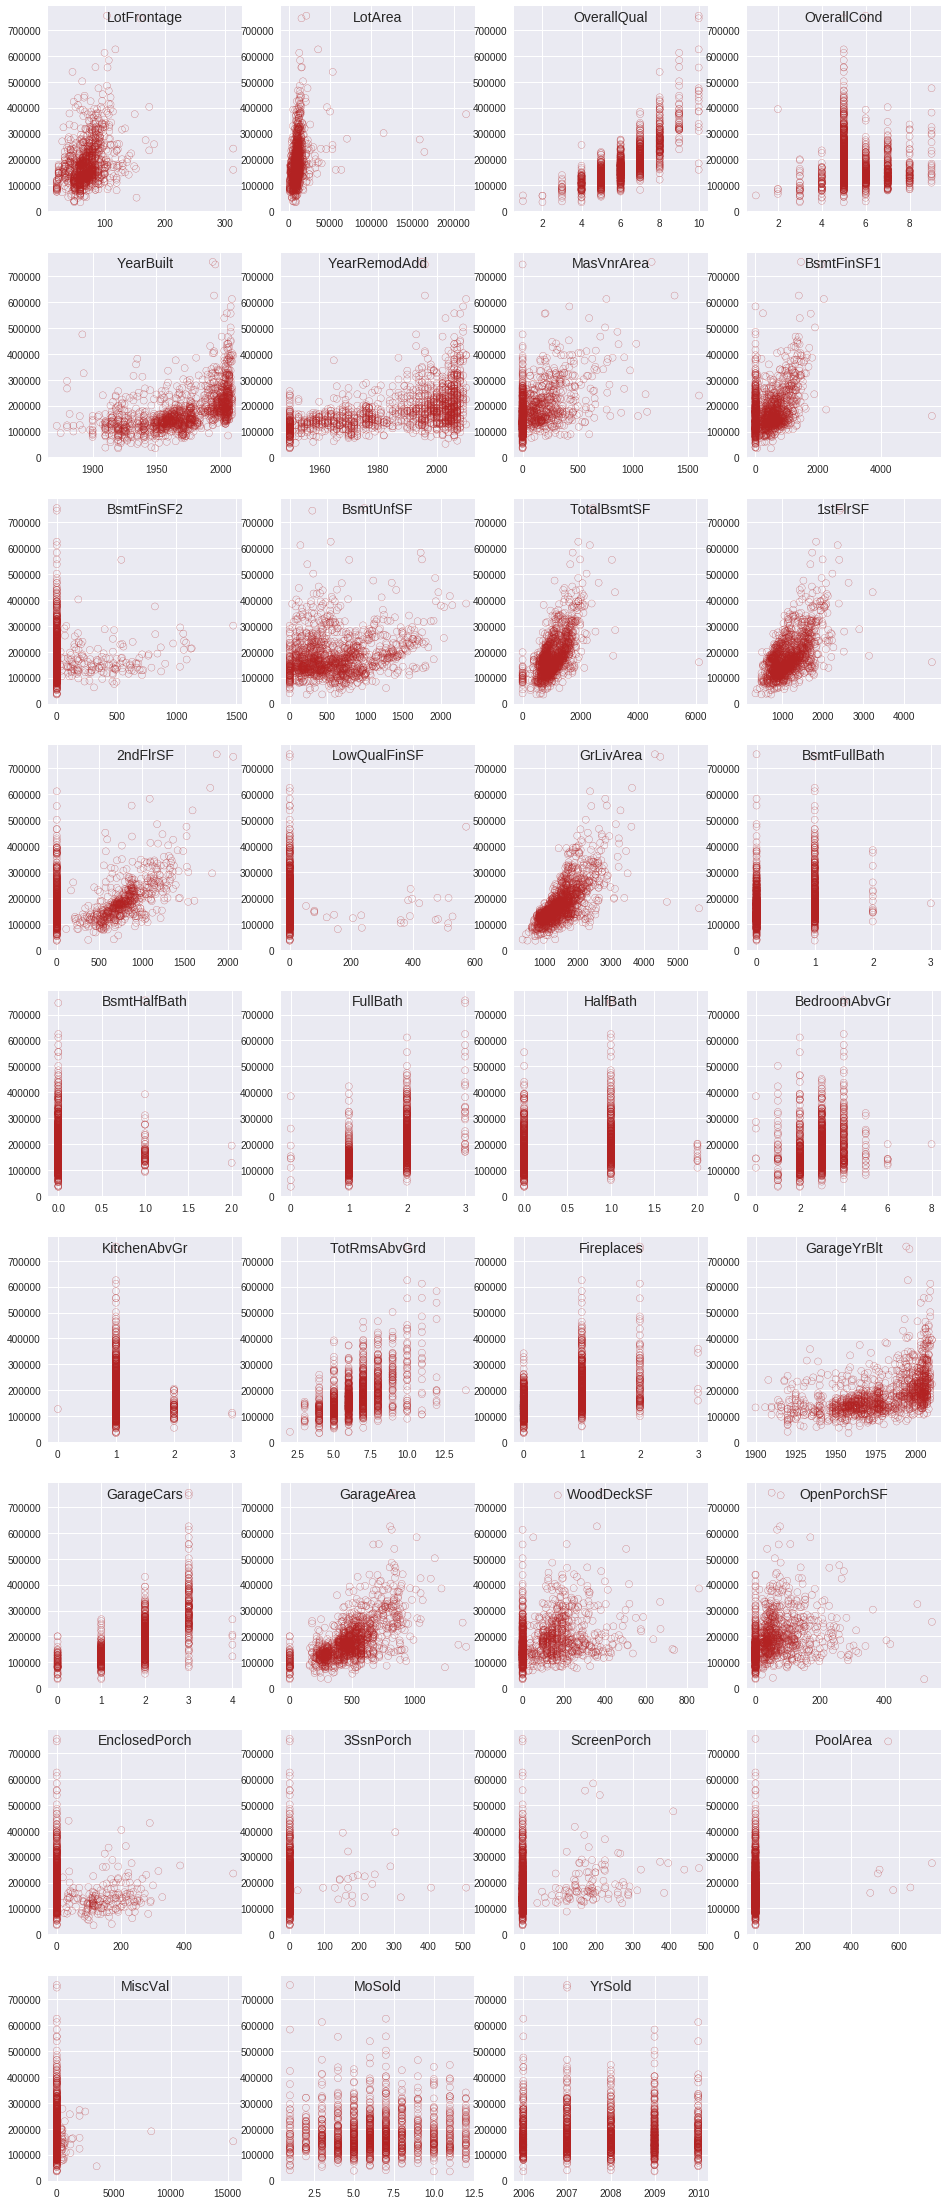

In [8]:
fig = plt.figure(figsize=(16,40))
for i, col in enumerate(df.select_dtypes(include=['int64', 'float64']).columns.drop(['Id', 'SalePrice'])):
    fig.add_subplot(9,4,i+1)
    plt.scatter(df[col], df['SalePrice'], alpha=0.7, facecolors='none', edgecolors='firebrick')
    plt.title(col, {'fontsize': 14}, y = 0.9)
    # used open circles with some transparency to help highlight the trends vs noise
    
plt.show()

#### What are your observations? Add them to this markdown cell.
---
|Variable|Observations|
| --- | :--- |
|LotFrontage|looks like some correlation. The correlation might be stronger if we cap valuse at 150 or 200? |
|LotArea|looks like there may be some correlation. Consider capping values at 50k|
|OverallQual|Clear correlation, though the error grows as quality goes up.|
|OverallCond|appears to be positively correlated with the exception of value 5. Maybe rescale so 5s = 0?|
|YearBuilt|maybe some postive correlation, but I wonder if `YearBuilt` is correlated with some other feature (Sq footage, # of bathrooms, etc)?|
|YearRemodAdd|Maybe a week correlation. I would expect this to correlate with `OverallCond`|
|BsmtFinSF1|Some postive correlation. 0 values may be throwing off the scatter plot, but I would expect 0 values will cancel themselves out in a regression (0 * beta = 0)|
|BsmtFinSF2|No apparent correlation|
|BsmtUnfSF|No apparent correlation|
|TotalBsmtSF|Definite positive corelation. May want to cap values as the 6000 value will throw off the fit.|
|1stFlrSF|Definite positive correlation. May want to cap some values|
|2ndFlrSF|Moderate positive correlation. No obvious outliers|
|LowQualFinSF|No apparent correlation|
|GrLivArea|Definite positive correlation|
|BsmtFullBath|Not much correlation. Maybe consider combining with `FullBath`|
|BsmtHalfBath|No apparent correlation. Consider combining with `HalfBath`|
|FullBath|Some upward correlation|
|HalfBath|No immediately apparent correlation|
|BedroomAbvGr|Some positve correlation|
|KitchenAbvGr|No apparent correlation|
|TotRmsAbvGrd|Definite positive correlation. Should bedrooms be subtracted? Bathrooms are always excluded|
|Fireplaces|Houses with fireplaces have higher prices, but it is unclear that price increases with additional fireplaces. Perhaps convert to a bool?|
|GarageYrBlt|Potentially a weak positive correlation?|
|GarageCars|Definite positive correlation|
|GarageArea|some positive correlation. Maybe choose this OR `GarageCars` as the Area likely correlates with Cars|
|WoodDeckSF|Some positive correlation. Maybe sum with `OpenPorchSF`, `EnclosedPorch`, `3SsnPorch`, and `ScreenPorch` to create an OutdoorLivingArea|
|OpenPorchSF|Some positive correlation|
|EnclosedPorch|Not enough cases to tell|
|3SsnPorch|Not enough cases to tell|
|ScreenPorch|Not enough cases to tell|
|PoolArea|Almost exclusively 0s, exclude.|
|MiscVal|Almost exclusively 0s, exclude.|
|MoSold|Some differentiation but no clear directional correlation. Maybe convert to categorical|
|YrSold|Maybe a downward trend? Hard to tell; may be best to convert to categorical|

In [9]:
# checking some assumptions about the data

# Basement 
assert np.mean(np.array(df['BsmtFinSF1'] + df['BsmtFinSF2'] + df['BsmtUnfSF']) == np.array(df['TotalBsmtSF']))
# TotalBsmtSF is a summation of the three other Bsmt SF featuers. Include the Total only (strongest looking relationship)


# Living Area
assert np.mean(np.array(df['1stFlrSF'] + df['2ndFlrSF'] + df['LowQualFinSF']) == np.array(df['GrLivArea']))
# GrLivArea is a summation of the three other SF featuers. Try including Total only (strongest looking relationship)


### D. Use bar plots to plot categorical features against `SalePrice`. 

**HINT:** Look up how to create bar plots in `matplotlib`. You will have to transform the data before you can create a bar plot! Also, look up [how to plot error bars](https://pandas.pydata.org/pandas-docs/stable/visualization.html#plotting-with-error-bars) so you can also observe the variability in your data!

In [10]:
len(df.select_dtypes(include=['object']).columns)

44

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


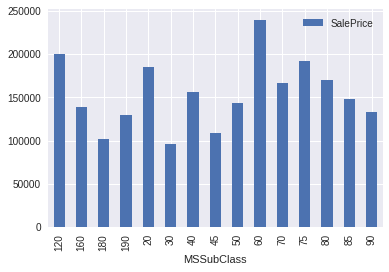

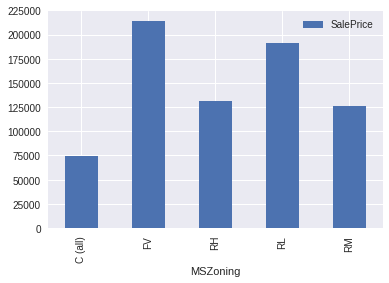

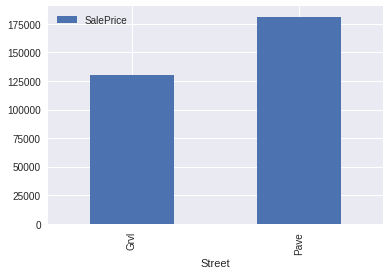

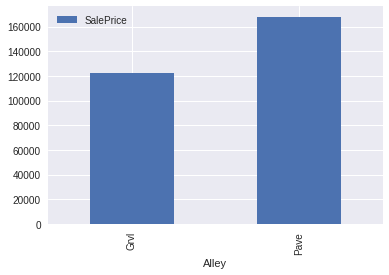

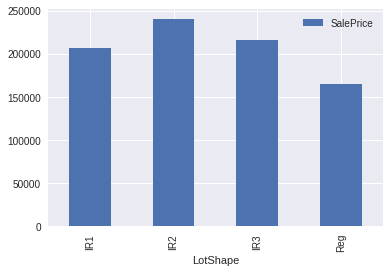

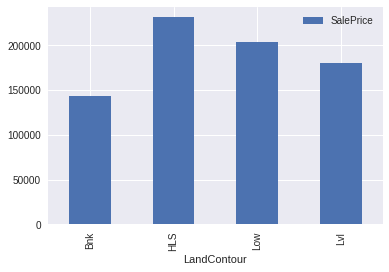

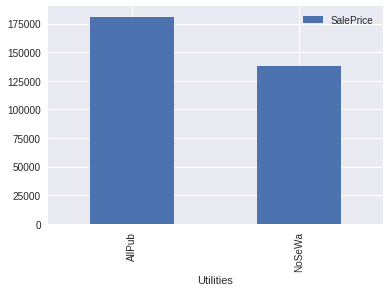

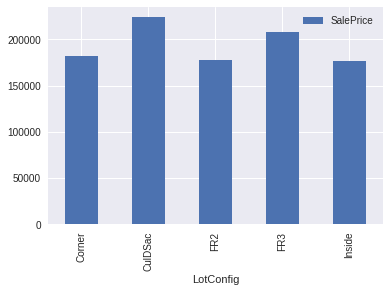

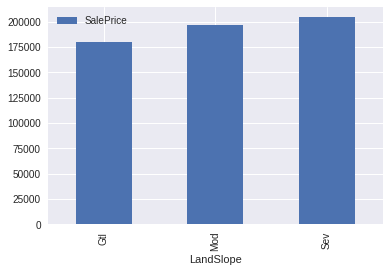

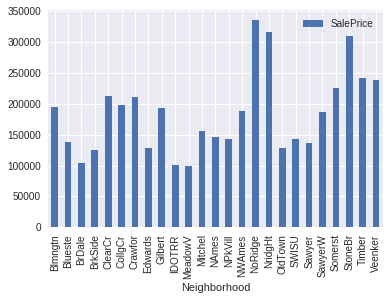

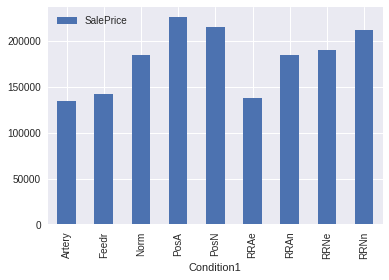

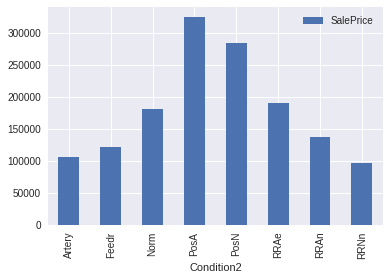

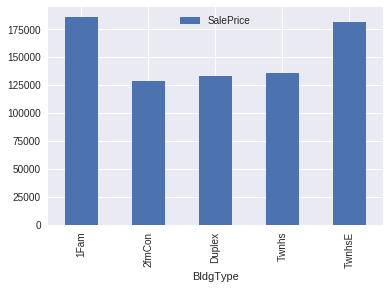

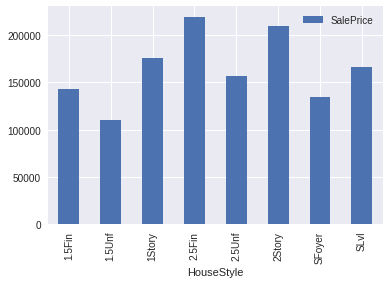

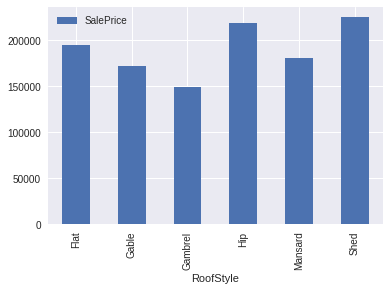

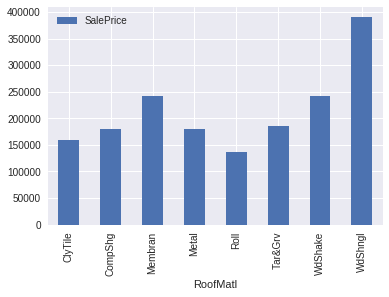

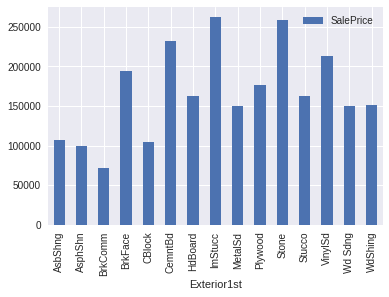

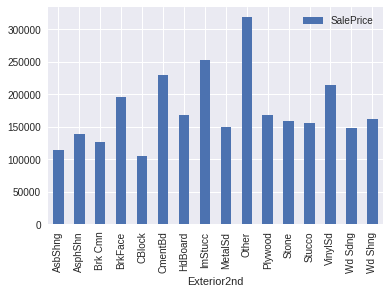

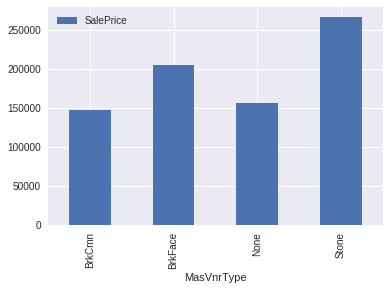

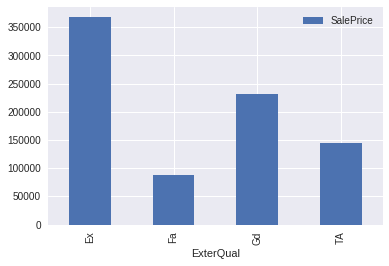

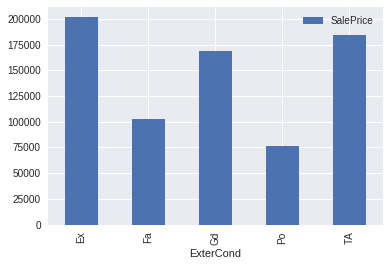

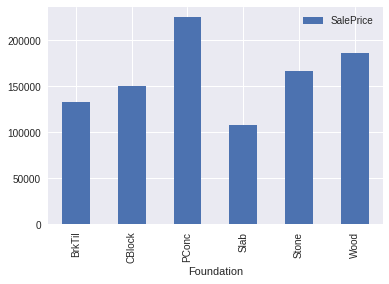

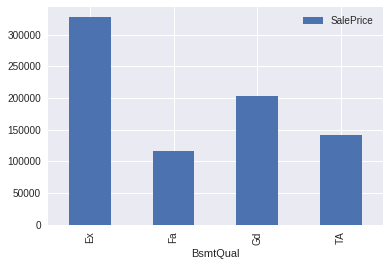

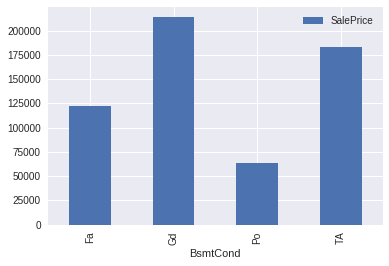

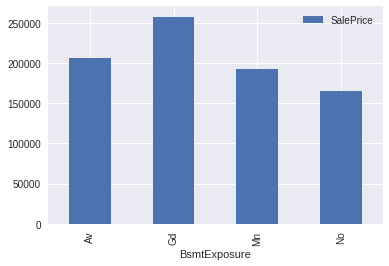

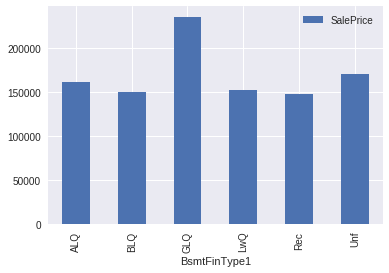

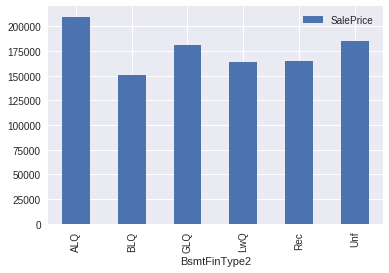

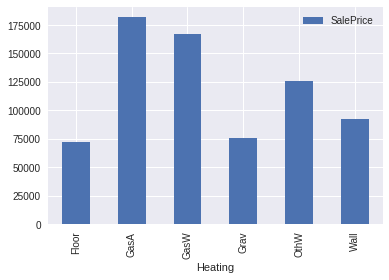

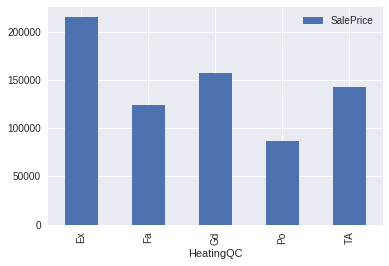

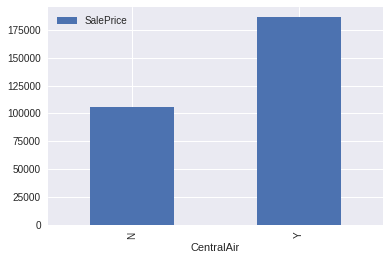

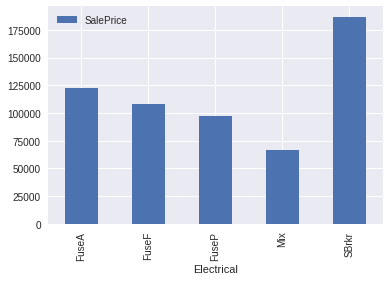

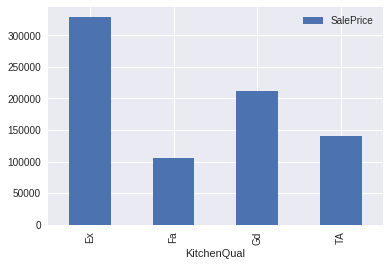

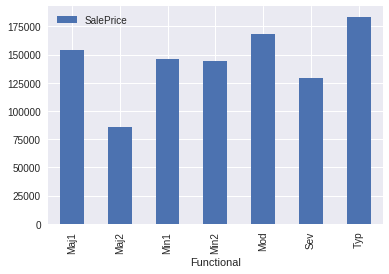

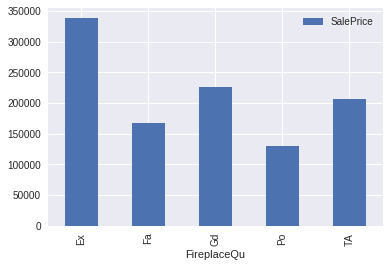

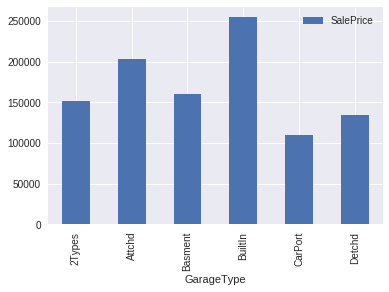

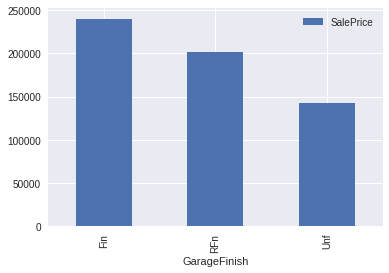

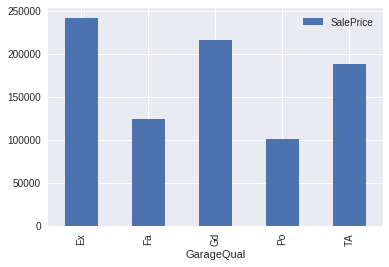

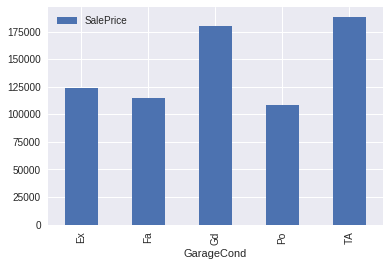

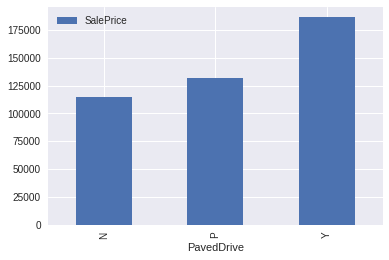

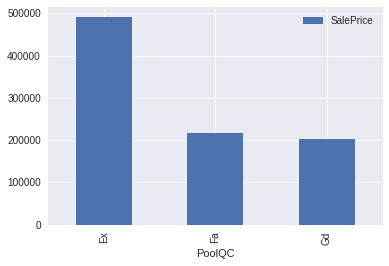

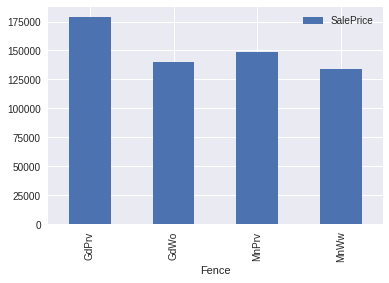

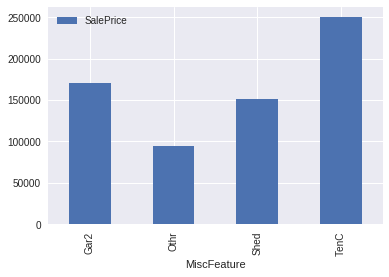

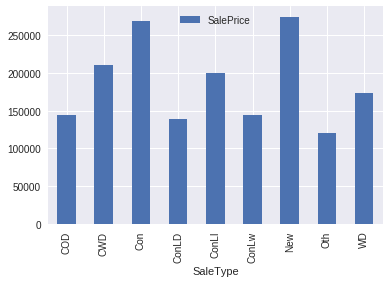

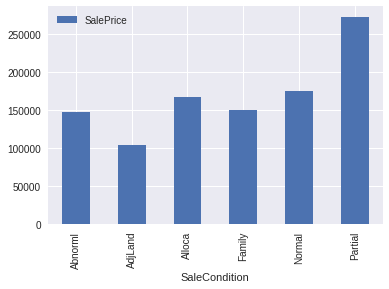

In [11]:
# fig = plt.figure(figsize=(16,40))
for i, col in enumerate(df.select_dtypes(include=['object']).columns):
    temp_df = df.loc[:, [col, 'SalePrice']]
    
#     fig.add_subplot(22,2,i+1)
    temp_df.groupby(col).mean().plot.bar()
    plt.plot()
    
# is there an easy way to plot the StDev or error bar on these? n size?
# Couldnt get this block to subplot properly

#### What are your observations? Add them to this markdown cell.

---

|Variable|Notes|
| -: | :-------------------------- | 
|MSSubClass|Clear differences in price, but I think the categories in this variable are embedded in other vars|
|MSZoning|Clear differentiation in prices|
|Street|Some differences in price but Gravel has very few cases; likely exclude|
|Alley|Some difference in price, but I am concerned about the base sizes of Alley|
|LotShape|Some differences in price|
|LandContour|Some difference sin price |
|Utilities|Some difference sin price but NoService has very few cases|
|LotConfig|Some differences in price |
|LandSlope|Very little difference in price|
|Neighborhood|Clear differentiation but may need grouping of similarly priced teirs |
|Condition1|Some differences across conditions. Likely will need some groupling |
|Condition2|Clear differentiation, but I think the base sizes are too small to include |
|BldgType|Some differentiation |
|HouseStyle|Clear differentiation, but I think the info contained in this variable is embedded in other vars|
|RoofStyle|Differentiation in price. May need groupings based on prior EDA |
|RoofMatl|Some differentiation |
|Exterior1st|Lots of differentiation. May need groups as per prior EDA |
|Exterior2nd|See `Exterior1st`|
|MasVnrType|None and BrkCmn show very little differentiation |
|ExterQual|Clear difference in price |
|ExterCond|Clear difference in price |
|Foundation|Lots of differentiation |
|BsmtQual|Not much difference between Fa and TA |
|BsmtCond|Clearly different mean Price for each group|
|BsmtExposure|It looks like Av and Mn could be combined, but clear differentiation otherwise |
|BsmtFinType1|GLQ is different from other categories |
|BsmtFinType2|Not sure the base sizes are deep enough to include this var |
|Heating|Some differentiation, but some categories seem like they could be grouped |
|HeatingQC|Fa and Po look like they can be grouped |
|CentralAir|huge difference in mean price |
|Electrical|SBkr show much higher price, but I think the frequency of other options was too low to include. Maybe a book for SBkr |
|KitchenQual|Huge differences in price |
|Functional|Some differences, but they arent huge. Check frequency counts |
|FireplaceQu|Some differences |
|GarageType|Definite differences, but it looks like some categories could be grouped|
|GarageFinish| Clear differences|
|GarageQual|Fa and Po look like they can be grouped |
|GarageCond|Ex has a lower mean price than TA or Gd, so there may not be a clear predictive value. Consider excluding |
|PavedDrive|Large differences |
|PoolQC|Too few entries to matter |
|Fence|Some differences |
|MiscFeature|
|SaleType|very clear differences |
|SaleCondition|

## 3. Preprocessing

### A. Identify and Remove Outliers for `SalePrice`

Make sure to... 
* Plot a histogram of the housing price. 
* Supply a definition of what an outlier is by your criteria. Does Tukey's method make sense with 1.5 times the interquartile range, or should that range be increased or decreased?
* Use masking to remove the outliers as you've defined them.

In [12]:
iqr_SalePrice = np.percentile(df['SalePrice'], 75) - np.percentile(df['SalePrice'], 25)
iqr_SalePrice
low_outliers_SalePrice = np.percentile(df['SalePrice'], 25) - (1.5*iqr_SalePrice)
high_outliers_SalePrice = np.percentile(df['SalePrice'], 75) + (3*iqr_SalePrice)
tukey_outlier = np.percentile(df['SalePrice'], 75) + (1.5*iqr_SalePrice)

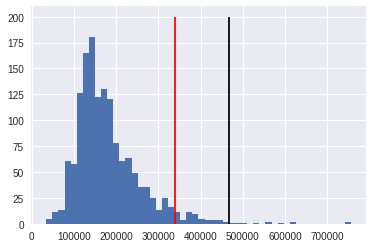

0.00821917808219


In [13]:
df['SalePrice'].hist(bins=50)
plt.vlines([high_outliers_SalePrice], ymin=0, ymax=200)
plt.vlines([tukey_outlier], ymin=0, ymax=200, colors='r')
plt.show()
print(sum(df['SalePrice'] >= high_outliers_SalePrice)/len(df))

## Interpretation

Using the Tukey outlier interpretation (1.5 \* IQR), illustrated by the red vertical line, feels aggressive to me. The Tukey outlier definition is usually associated with Normal distributions, but `SalePrice` appears to be right skewed and abnormal. The Tukey definition appears to cut off the distribution before it approaches 0. Instead, I have decided to use a threshould of 3.0 \* IQR, illustrated by the black line, to identify outliers. The resulting distribution appears to be continous without any noticable outliers.

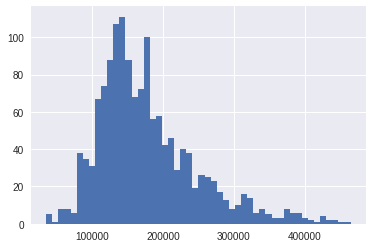

In [14]:
mask_saleprice = df['SalePrice'] < high_outliers_SalePrice
df_trim = df.loc[mask_saleprice, :]
df_trim['SalePrice'].hist(bins=50)

### B. Fill missing data!

* How many null values are in each column? Make a bar plot showing this only for columns with missing data.
* For each column with nulls, do nulls represent anything? Read the data description.
  * Some columns that are appearing as _null_ might legitimately be known (ie: "na").  Double check the [data description](../data_description.txt) for proper value representation.  A feature might actually be better represented by "not available" or "na" rather than `NULL` or `NaN`.  There's a difference between `NULL` (unknown), and "NA" (not available).  It might mean the difference between "there isn't a garage" and "there is no garage data". 
* Fill null values for each column by imputation. Here are some common methods for imputation:
  1. Using domain knowledge to select an appropriate value.
  1. Value from a randomly selected row.
  2. Mean, median, or mode value of the series.
  3. Value estimated by a predictive model.
* Make sure to justify your method for filling null values.
  

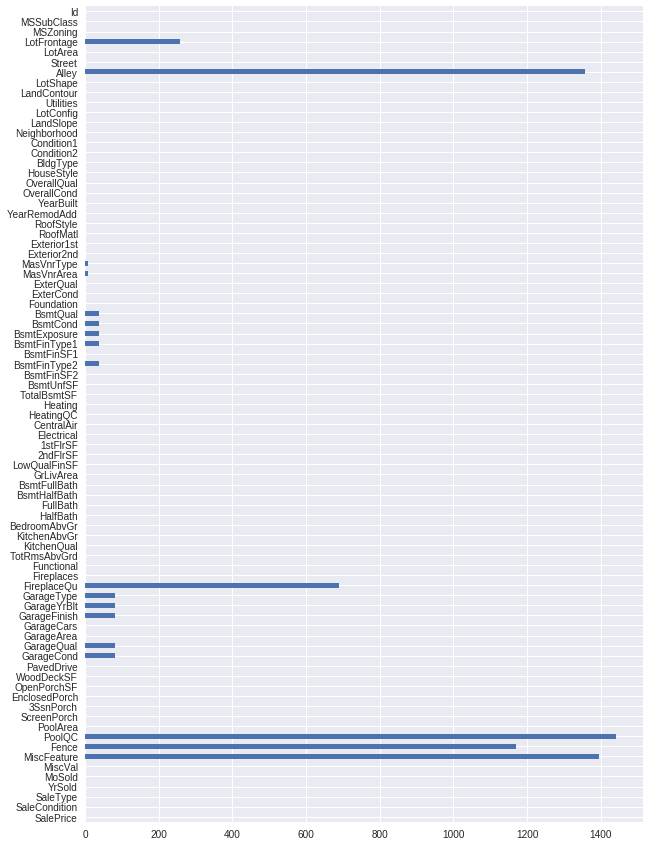

In [15]:
fig = plt.figure(figsize=(10,15))
df_trim.isnull().sum().plot.barh().invert_yaxis()
# plt.invert_yaxis()

Verify that you have *truly* eliminated all the null values!

* **LotFrontage** - Data Dictionary does not indicate that NAs have a particular meaning. I expect these cases are associated with high density housing. Replace NAs with 0s should be fine.
* **Ally** - NAs indicate no alleys. I will likely leave as in and convert Ally to a Bool for Alley vs No
* **MasVnrType** - NAs indicate no Masonry. Will likely leave as is and convert to dummy columns. Cases where all dummy columns = False will represent the cases without any Masonry Veneer 
* **MasVnrArea** - Will fill NAs with 0
* **BsmtQual** - NAs indicate no basement. Will likely leave as is and convert to dummy columns (after grouping)
* **BsmtCond** - NAs indicate no basement. Will likely leave as is and convert to dummy columns 
* **BsmtExposure** - NAs indicate no basement. Will likely leave as is and convert to dummy columns 
* **BsmtFinType1** - NAs indicate no basement. Will likely leave as is and convert to dummy columns 
* **BsmtFinType2** - NAs indicate no basement. Will likely leave as is and convert to dummy columns 
* **FireplaceQu** - NAs indicate no Fireplaces. Will likely leave as is and convert to dummy columns 
* **GarageType** - NAs indicate no Garage. Will leave as is and convert to dummy columns
* **GarageYrBlt** - NAs indicate no Garage. I may exclude this column, but will replace NAs with 0s in case I keep it. 
* **GarageFinish** - NAs indicate no Garage. Will leave as is and convert to dummy columns
* **GarageQual** - NAs indicate no Garage. Will leave as is and convert to dummy columns
* **GarageCond** - NAs indicate no Garage. Will leave as is and convert to dummy columns
* **PoolQC** - NAs indicate no Pool. This column will be dropped since so few cases have pools.
* **Fence** - NAs indicate no Fence. Will leave as is and convert to dummy columns
* **MiscFeature** - Nas indicate no miscellaneous features. I will likely drop this colummn. 

In [16]:
# removing commercial properties. 
# My assumption is that commercial properties have different attributes that drive SalePrice
df_trim = df_trim.loc[df_trim.MSZoning != 'C (all)',] 

In [17]:
# Fill missing values with 0s
df_trim['LotFrontage'] = df_trim['LotFrontage'].mask(df_trim['LotFrontage'].isnull(), 0)
df_trim['MasVnrArea'] = df_trim['MasVnrArea'].mask(df_trim['MasVnrArea'].isnull(), 0)
df_trim['GarageYrBlt'] = df_trim['GarageYrBlt'].mask(df_trim['GarageYrBlt'].isnull(), 0)

# Create Bools for Alley
df_trim.loc[:,'Alley'] = ~df_trim['Alley'].astype(bool)

#dropping (mostly) categorical columns that won't be used
df_trim.drop(['PoolQC', 
              'PoolArea',
              'MiscFeature', 
              'MSSubClass', 
              'Street', 
              'Utilities', 
              'Condition2',
              'Heating',
              'GarageQual',
              'GarageCond'], axis = 1, inplace=True)

### Decided to skip filling nulls for categorical values and run get_dummies() with null values. 
Null cases can be identified where the other dummy columns = 0. For example, take an imaginary case of Gender with possible responses of 'Male', 'Female', and Null. When converting to dummy variables, you hold the same amount of meaningful information with 2 columns as 3. Cases where Gender_Male == 0 & Gender_Female == 0 explicitly mean that Gender_Null == 1, therefore you dont need the Gender_Null column. 

In [18]:
df_trim.select_dtypes(include=['int64', 'float64']).columns

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold',
       'YrSold', 'SalePrice'],
      dtype='object')

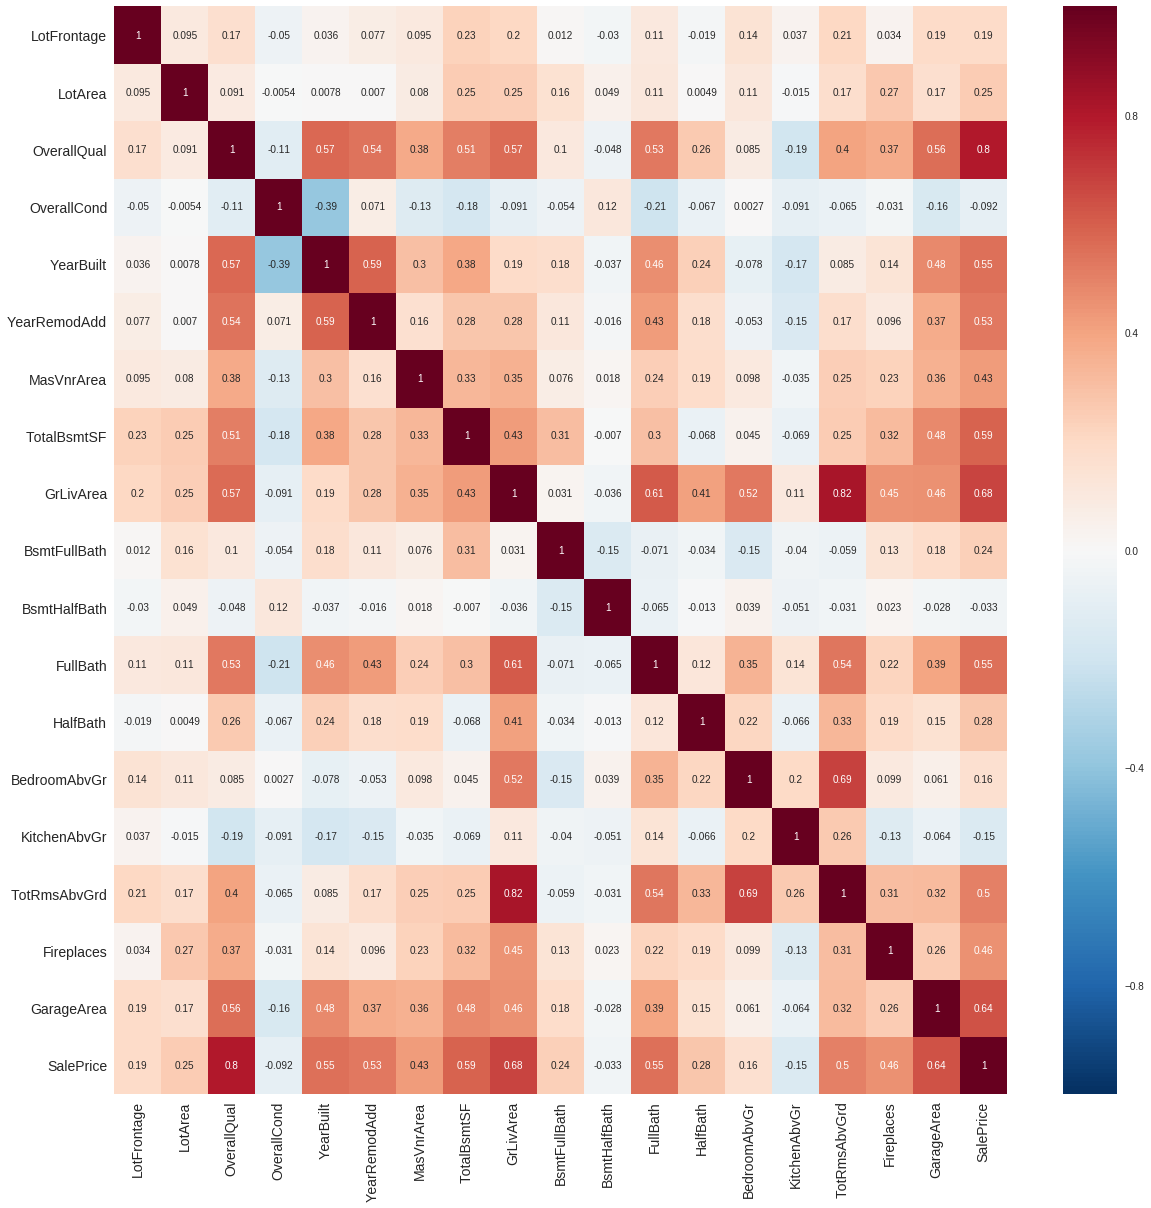

In [19]:
# playing around with heatmaps/correlations
hm_columns = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 
              'MasVnrArea', 'TotalBsmtSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 
              'HalfBath','BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 
              'SalePrice']

temp_df = pd.DataFrame(df_trim[hm_columns])

# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(temp_df.corr(), ax=ax, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

### C. Create dummy variables for categorical columns

Use `pd.get_dummies()` to turn your categorical features into numeric features. Make sure there are **no null values** in your dataset before you do this!

In [20]:
df_dummies = pd.get_dummies(df_trim)
df_dummies.head()

,Id,LotFrontage,LotArea,Alley,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,False,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,80.0,9600,False,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,68.0,11250,False,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,60.0,9550,False,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,84.0,14260,False,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


# Additional munging/cleaning here.
**Types of operations:**
* Combining low frequency categories (such as `Po` and `Fa` for some of the `[X]Qual` variables 
* Recoding some outliers to a determined max() value. Alternatively, clean out these cases
* Dropping the `drop` columns created by `get_dummies()`
* Dropping columns with little differentiation

In [21]:
# final cleaning of features
df_modeling = df_dummies

#set index and drop 'Id' column
df_modeling.set_index('Id')

#converting MoSold and YrSold to object columns, then creating dummies
df_modeling['MoSold'] = df_modeling['MoSold'].astype(str)
df_modeling['YrSold'] = df_modeling['YrSold'].astype(str)
df_modeling = pd.get_dummies(df_modeling)

# MsZoning - gorup RH and RM, drop original columns
df_modeling['MSZoning_RMH'] = df_modeling['MSZoning_RM'] + df_modeling['MSZoning_RH']
df_modeling.drop(['MSZoning_RM', 'MSZoning_RH'], axis = 1, inplace = True)

# LotShape - group IR2 and IR3, dropping original columns
df_modeling['LotShape_IR23'] = df_modeling['LotShape_IR2'] + df_modeling['LotShape_IR3']
df_modeling.drop(['LotShape_IR2', 'LotShape_IR3'], axis = 1, inplace = True)

# LandCountour - dropping HLS, Low, and Bnk cases. This essentially turns LandCountour_Lvl into a bool for all options
df_modeling.drop(['LandContour_Bnk', 'LandContour_HLS', 'LandContour_Low'], axis = 1, inplace = True)

# LotConfig - dropping FR2, FR3, and CulDSac due to low counts
df_modeling.drop(['LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3'], axis = 1, inplace = True)

# LandSlope - dropping Mod and Sev columns due to low counts
df_modeling.drop(['LandSlope_Mod', 'LandSlope_Sev'], axis = 1, inplace = True)

# Condition1 - group to Norm vs RR, dropping others
df_modeling['Condition1_RR'] = df_modeling['Condition1_RRAe'] + df_modeling['Condition1_RRAn'] + \
                                df_modeling['Condition1_RRNe'] + df_modeling['Condition1_RRNn'] 
df_modeling.drop(['Condition1_Artery', 'Condition1_Feedr', 'Condition1_PosA', 'Condition1_PosN', 
                  'Condition1_RRAe', 'Condition1_RRAn', 'Condition1_RRNe', 'Condition1_RRNn'], axis = 1, inplace = True)

# BldgType - Group to 1Fam vs TwnHse, dropping others
df_modeling['BldgType_Twnhs'] = df_modeling['BldgType_Twnhs'] + df_modeling['BldgType_TwnhsE']
df_modeling.drop(['BldgType_2fmCon', 'BldgType_Duplex', 'BldgType_TwnhsE'], axis = 1, inplace = True)

# RoofStyle - dropping Gambrel, Shed, Mansard, and Flat
df_modeling.drop(['RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofStyle_Mansard', 'RoofStyle_Shed'], axis = 1, inplace = True)

# RoofMaterial - dropping all but CompShg due to low counds
df_modeling.drop(['RoofMatl_ClyTile', 'RoofMatl_Membran', 'RoofMatl_Metal','RoofMatl_Roll', 
                  'RoofMatl_Tar&Grv', 'RoofMatl_WdShake', 'RoofMatl_WdShngl'], axis = 1, inplace = True)

# Exterior1st and 2nd - dropping categoirs with low counts
df_modeling.drop(['Exterior1st_AsbShng', 'Exterior1st_AsphShn', 'Exterior1st_BrkComm', 'Exterior1st_BrkFace', 
                  'Exterior1st_CBlock', 'Exterior1st_CemntBd', 'Exterior1st_ImStucc', 
                  'Exterior1st_Stone', 'Exterior1st_Stucco', 'Exterior1st_WdShing'], axis = 1, inplace = True)
df_modeling.drop(['Exterior2nd_AsbShng', 'Exterior2nd_AsphShn', 'Exterior2nd_Brk Cmn', 'Exterior2nd_BrkFace', 
                  'Exterior2nd_CBlock', 'Exterior2nd_CmentBd', 'Exterior2nd_ImStucc', 
                  'Exterior2nd_Stone', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Shng'], axis = 1, inplace = True)

# MasVnrType - grouping Bricks and keeping Stone. Dropping None
df_modeling['MasVnrType_Brk'] = df_modeling['MasVnrType_BrkCmn'] + df_modeling['MasVnrType_BrkFace']
df_modeling.drop(['MasVnrType_BrkCmn', 'MasVnrType_BrkFace', 'MasVnrType_None'], axis = 1, inplace = True)

# ExterQual - grouping Fa and TA
df_modeling['ExterQual_FaTA'] = df_modeling['ExterQual_Fa'] + df_modeling['ExterQual_TA']
df_modeling.drop(['ExterQual_TA', 'ExterQual_Fa'], axis = 1, inplace = True)

# ExterCond - grouping TA + Fa + Po, Gd+Ex
df_modeling['ExterQual_PoFaTA'] = df_modeling['ExterCond_Po'] + df_modeling['ExterCond_Fa'] + df_modeling['ExterCond_Fa']
df_modeling['ExterQual_GdEx'] = df_modeling['ExterCond_Gd'] + df_modeling['ExterCond_Ex']
df_modeling.drop(['ExterCond_Ex', 'ExterCond_Fa', 'ExterCond_Gd', 'ExterCond_Po', 'ExterCond_TA'], axis = 1, inplace = True)

# Foundation - dropping Slap, Wood, and Stone due to low counts
df_modeling.drop(['Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood'], axis = 1, inplace = True)

# BsmtQual - combining Fa+TA
df_modeling['BsmtQual_FaTA'] = df_modeling['BsmtQual_Fa'] + df_modeling['BsmtQual_TA']
df_modeling.drop(['BsmtQual_Fa', 'BsmtQual_TA'], axis = 1, inplace = True)

# BsmtCond - combining Po+Fa
df_modeling['BsmtQual_PoFa'] = df_modeling['BsmtCond_Po'] + df_modeling['BsmtCond_Fa']
df_modeling.drop(['BsmtCond_Po', 'BsmtCond_Fa'], axis = 1, inplace = True)

# BsmtFinType2 - dropping all but unfinished due to low counts
df_modeling.drop(['BsmtFinType2_ALQ', 'BsmtFinType2_BLQ', 'BsmtFinType2_GLQ', 'BsmtFinType2_LwQ', 'BsmtFinType2_Rec'], axis = 1, inplace = True)

# HeatingQC - combining Fa+Ta
df_modeling['HeatingQC_FaTA'] = df_modeling['HeatingQC_Fa'] + df_modeling['HeatingQC_TA']
df_modeling.drop(['HeatingQC_Fa', 'HeatingQC_TA'], axis = 1, inplace = True)

# CentralAir - dropping Ns as the info is already encoded in the Ys (where Ys == 0 ~= N)
df_modeling.drop(['CentralAir_N'], axis = 1, inplace = True)

# Electrical - dropping all but SBrkr due to low counts
df_modeling.drop(['Electrical_FuseA', 'Electrical_FuseF', 'Electrical_FuseP', 'Electrical_Mix'], axis = 1, inplace = True)

# KitchenQual - combining Fa+TA
df_modeling['KitchenQual_FaTA'] = df_modeling['KitchenQual_Fa'] + df_modeling['KitchenQual_TA']
df_modeling.drop(['KitchenQual_Fa', 'KitchenQual_TA'], axis = 1, inplace = True)

# Functional - removing all but Typ due to low counts
df_modeling.drop(['Functional_Maj1', 'Functional_Maj2', 'Functional_Min1', 'Functional_Min2', 
                  'Functional_Mod', 'Functional_Sev'], axis = 1, inplace = True)

# FireplaceQu - grouping TA + Fa + Po, Gd+Ex
df_modeling['FireplaceQu_PoFaTA'] = df_modeling['FireplaceQu_Po'] + df_modeling['FireplaceQu_Fa'] + df_modeling['FireplaceQu_Fa']
df_modeling['FireplaceQu_GdEx'] = df_modeling['FireplaceQu_Gd'] + df_modeling['FireplaceQu_Ex']
df_modeling.drop(['FireplaceQu_Ex', 'FireplaceQu_Fa', 'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA'], axis = 1, inplace = True)

# GarageType - Removing all but Attchd and Detchd
df_modeling.drop(['GarageType_2Types', 'GarageType_Basment', 'GarageType_BuiltIn', 'GarageType_CarPort'], axis = 1, inplace = True)

# Paved - only keeping Y
df_modeling.drop(['PavedDrive_N', 'PavedDrive_P'], axis = 1, inplace = True)

# Fence - combining to Mn vd Gd
df_modeling['Fence_Gd'] = df_modeling['Fence_GdWo'] + df_modeling['Fence_GdPrv']
df_modeling['Fence_Mn'] = df_modeling['Fence_MnPrv'] + df_modeling['Fence_MnWw']
df_modeling.drop(['Fence_GdPrv', 'Fence_GdWo', 'Fence_MnPrv', 'Fence_MnWw'], axis = 1, inplace = True)

# SaleType - dropping all but WD, New due to low counts
df_modeling.drop(['SaleType_COD', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLD', 'SaleType_ConLI', 
                  'SaleType_ConLw', 'SaleType_Oth'], axis = 1, inplace = True)

# SaleConding - dropping all but Normal, Abnormal, and Partial due to low counds
df_modeling.drop(['SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family'], axis = 1, inplace = True)

# Removing 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF' as TotalBsmtSF is a summation of all three
df_modeling.drop(['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'], axis = 1, inplace = True)

# creating a total outdoor living area.
df_modeling['OutdoorLivingSF'] = df_modeling['OpenPorchSF'] + df_modeling['EnclosedPorch'] + \
                                 df_modeling['3SsnPorch'] + df_modeling['ScreenPorch'] + df_modeling['WoodDeckSF']
df_modeling.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'], axis = 1, inplace = True)

# dropping components of GrLivArea
df_modeling.drop(['1stFlrSF', '2ndFlrSF', 'LowQualFinSF'], axis = 1, inplace = True)

# dropping GarageCars as it should be correlated with GarageArea
df_modeling.drop(['GarageCars'], axis = 1, inplace = True)

In [22]:
# removing cases where LotArea >= 50000. Likely could restrict more
df_modeling = df_modeling.loc[df_modeling['LotArea'] < 50000, :]
#df_modeling.loc[df_modeling['LotArea'] > 40000, :].shape

### D. Split your data into a train and test set.

* Use `train_test_split` to hold out a test set. 
* Why do we hold out a test set?

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X = df_modeling.drop(['SalePrice', 'Id'], axis = 1)
y = df_modeling['SalePrice']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 42) #hold 25% for testing
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(714, 152) (714, 152) (714,) (714,)


We hold out a test set because we need to understand how our model performs on data it hasn't seen. We may create a model that fits our training data very well but does not score well on the test set, suggesting that it won't predict well given new data (i.e. overfitting.) With a test set, we can understand how our model performs on unseen data.

### E. Scale the data

Make sure to...
* instantiate a `StandardScaler` object
* `fit` the scaler on your training data
* `transform` both your training and test data.

In [27]:
from sklearn.preprocessing import StandardScaler

In [28]:
scale = StandardScaler()

scale.fit(X_train)
X_train_scale = scale.transform(X_train)
X_test_scale = scale.transform(X_test)

print(X_train_scale.shape, X_test_scale.shape) # hazard check

(714, 152) (714, 152)


## 4. Modeling

Now that you've completed your EDA, you can now use your training data to build a model to predict home price from your features! As far as regression methods, you've learned a few, including ordinary least squares (a.k.a. `LinearRegression`), `Lasso`, `Ridge`, and `ElasticNet`. 

### A. Benchmarking

As we get started with modeling we should have some basis for comparison to get a sense of what a "good" model is for this task. 

For this task, as we will be focusing on linear models, we will use the most naive of the linear models, the Linear Regression as our benchmark. 

In [29]:
from sklearn.linear_model import LinearRegression

#### Results Dictionary

Make a results `list` to hold your results. After each model fit and score, you will add a dictionary of your results to this list using `.append()`. This will give you a list of dictionaries ... perfect for a DataFrame!

This is the pattern you will be using:

In [30]:
example_results = list()
result_1 = {'name':'test1','dataset' : 'train','preprocessing': 'raw','score': '1 bajillion'}
example_results.append(result_1)
result_2 = {'name':'test1','dataset' : 'train','preprocessing': 'scaled','score': '20 bajillion'}
example_results.append(result_2)

Then we pass the results list to pass to a DataFrame.

In [31]:
pd.DataFrame(example_results)

,dataset,name,preprocessing,score
0,train,test1,raw,1 bajillion
1,train,test1,scaled,20 bajillion


This gives us a convenient tool for manipulating our results and tracking our work ... our old friend, Pandas!

#### Make a new results list.

In [32]:
results = list()

#### Raw Benchmark

Instantiate a new `LinearRegression` model and save it as `benchmark_raw`.

In [33]:
benchmark_raw = LinearRegression()

- Fit the `benchmark_raw` model against the raw training data. 
- Score the `benchmark_raw` model against both the raw training set and the raw testing set. 
- Apprend a results dictionary to the `results` list. 

You could do this by

    results.append({'name':'benchmark',
                    'model': benchmark_raw,
                    'dataset' : 'train',
                    'preprocessing': 'raw',
                    'score': raw_train_score})
                    
Of course you can store a model in a dictionary!                    

In [34]:
benchmark_raw.fit(X_train, y_train)
raw_train_score = benchmark_raw.score(X_train, y_train)
raw_test_score = benchmark_raw.score(X_test, y_test)

results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})
results.append({'name':'benchmark',
                'model':benchmark_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

#### Scaled Benchmark

- Fit the `benchmark_scaled` model against the scaled training data. 
- Score the `benchmark_scaled` model against both the scaled training set and the scaled testing set. 
- Write the results to the results `list`. 

In [35]:
benchmark_scaled = LinearRegression()
benchmark_scaled.fit(X_train_scale, y_train)
scale_train_score = benchmark_scaled.score(X_train_scale, y_train)
scale_test_score = benchmark_scaled.score(X_test_scale, y_test)

results.append({'name':'benchmark scale',
                'model':benchmark_scaled,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scale_train_score})
results.append({'name':'benchmark scale',
                'model':benchmark_scaled,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scale_test_score})

Use a DataFrame to display your results.

In [37]:
pd.DataFrame(results)

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.139065e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.747370e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark scale,scaled,9.139027e-01
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark scale,scaled,-9.095378e+19


#### What are your observations? Add them to this markdown cell.

---
* Something seems off with the score for the `X_test_scaled` model. How is it outside of the 0-1 range? 
    * Extreme overfitting? 
    * Try cleaning inbound features
* Test score for raw data is actually pretty decent.

### B. Naive Regularization

Next, prepare a series of fits using the three regularized linear regression models with their default settings.

Perform each of these against both the raw and the scaled data. In this section, you should be fitting six models.

- A naive Ridge Regression against the raw data
- A naive Lasso Regression against the raw data
- A naive ElasticNet Regression against the raw data
- A naive Ridge Regression against the scaled data
- A naive Lasso Regression against the scaled data
- A naive ElasticNet Regression against the scaled data

**NOTE:** By "naive" we mean using all of the default settings.

In [38]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# For Revision: See about functionalizing the work below

In [39]:
#Raw Ridge
ridge_raw = Ridge()
ridge_raw.fit(X_train, y_train)
ridge_raw_train_score = ridge_raw.score(X_train, y_train)
ridge_raw_test_score = ridge_raw.score(X_test, y_test)

results.append({'name':'Ridge',
                'model':ridge_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': ridge_raw_train_score})
results.append({'name':'Ridge',
                'model':ridge_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': ridge_raw_test_score})

In [40]:
#Scaled Ridge
ridge_scale = Ridge()
ridge_scale.fit(X_train_scale, y_train)
ridge_scale_train_score = ridge_scale.score(X_train_scale, y_train)
ridge_scale_test_score = ridge_scale.score(X_test_scale, y_test)

results.append({'name':'Ridge scale',
                'model':ridge_scale,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': ridge_scale_train_score})
results.append({'name':'Ridge scale',
                'model':ridge_scale,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': ridge_scale_test_score})

In [41]:
#Raw Lasso
lasso_raw = Lasso(max_iter = 10000)
lasso_raw.fit(X_train, y_train)
lasso_raw_train_score = lasso_raw.score(X_train, y_train)
lasso_raw_test_score = lasso_raw.score(X_test, y_test)

results.append({'name':'Lasso',
                'model':lasso_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': lasso_raw_train_score})
results.append({'name':'Lasso',
                'model':lasso_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': lasso_raw_test_score})

In [42]:
#Scaled Lasso
lasso_scale = Lasso(max_iter = 10000)
lasso_scale.fit(X_train_scale, y_train)
lasso_scale_train_score = lasso_scale.score(X_train_scale, y_train)
lasso_scale_test_score = lasso_scale.score(X_test_scale, y_test)

results.append({'name':'Lasso scale',
                'model':lasso_scale,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': lasso_scale_train_score})
results.append({'name':'Lasso scale',
                'model':lasso_scale,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': lasso_scale_test_score})

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [43]:
#Raw ElasticNet
elasticnet_raw = ElasticNet()
elasticnet_raw.fit(X_train_scale, y_train)
elasticnet_raw_train_score = elasticnet_raw.score(X_train_scale, y_train)
elasticnet_raw_test_score = elasticnet_raw.score(X_test_scale, y_test)

results.append({'name':'ElasticNet',
                'model':elasticnet_raw,
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': elasticnet_raw_train_score})
results.append({'name':'ElasticNet',
                'model':elasticnet_raw,
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': elasticnet_raw_test_score})

In [44]:
#Scaled ElasticNet
elasticnet_scale = ElasticNet()
elasticnet_scale.fit(X_train_scale, y_train)
elasticnet_scale_train_score = elasticnet_scale.score(X_train_scale, y_train)
elasticnet_scale_test_score = elasticnet_scale.score(X_test_scale, y_test)

results.append({'name':'ElasticNet scale',
                'model':elasticnet_scale,
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': elasticnet_scale_train_score})
results.append({'name':'ElasticNet scale',
                'model':elasticnet_scale,
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': elasticnet_scale_test_score})

Note that we see warnings here. As we are in an exploration phase with our model, this is acceptable.

Use a DataFrame to store your `results` as `results_df`. By this we mean, save the `results` list into a new dataframe so that you can manipulate the DataFrame.

In [45]:
results_df = pd.DataFrame(results)
# results_df

#### Display just the raw test results using pandas

You can do this using pandas indexing as follows

    results_df[(results_df.preprocessing == 'raw') & 
               (results_df.dataset == 'test')]

In [46]:
results_df[(results_df.preprocessing == 'raw') & (results_df.dataset == 'test')]

,dataset,model,name,preprocessing,score
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,0.874737
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,0.882730
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,0.875242
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet,raw,0.891166


#### What are your observations? Add them to this markdown cell.

---
All of the models are showing relatively strong scores of > 0.85. The `Benchmark` and `Lasso` models are very close, with `Ridge` being slightly better and `ElasticNet` being the strongest performer. 


#### Display just the scaled test results

In [47]:
results_df[(results_df.preprocessing == 'scaled') & (results_df.dataset == 'test')]

,dataset,model,name,preprocessing,score
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark scale,scaled,-9.095378e+19
7,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge scale,scaled,8.755950e-01
11,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso scale,scaled,8.748880e-01
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet scale,scaled,8.911657e-01


#### What are your observations? Add them to this markdown cell.

---
* Something is still off with the `benchmark scale` model. The score is **bad**.
* The `Ridge` model looks *slightly* weaker than the `Raw Ridge` model.
* The `Lasso` model looks approximately as strong here as the `Raw Lasso` model.
* The `ElasticNet` model has the same score using both the scaled and raw data. I believe this is because the `ElasticNet` model scales data internally within the model.


These are your benchmark results. You will refer to these for analysis during the next phase.

#### Display just the Benchmark models

In [48]:
results_df[(results_df.name.str.contains('bench'))]

,dataset,model,name,preprocessing,score
0,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,9.139065e-01
1,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark,raw,8.747370e-01
2,train,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark scale,scaled,9.139027e-01
3,test,"LinearRegression(copy_X=True, fit_intercept=Tr...",benchmark scale,scaled,-9.095378e+19


#### Display just the Ridge models

In [49]:
results_df[(results_df.name.str.contains('Ridge'))]

,dataset,model,name,preprocessing,score
4,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,0.913383
5,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge,raw,0.882730
6,train,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge scale,scaled,0.913900
7,test,"Ridge(alpha=1.0, copy_X=True, fit_intercept=Tr...",Ridge scale,scaled,0.875595


#### Display just the Lasso models

In [50]:
results_df[(results_df.name.str.contains('Lasso'))]

,dataset,model,name,preprocessing,score
8,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,0.913903
9,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso,raw,0.875242
10,train,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso scale,scaled,0.913906
11,test,"Lasso(alpha=1.0, copy_X=True, fit_intercept=Tr...",Lasso scale,scaled,0.874888


#### Display just the Elasticnet models

In [51]:
results_df[(results_df.name.str.contains('Elastic'))]

,dataset,model,name,preprocessing,score
12,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet,raw,0.894781
13,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet,raw,0.891166
14,train,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet scale,scaled,0.894781
15,test,"ElasticNet(alpha=1.0, copy_X=True, fit_interce...",ElasticNet scale,scaled,0.891166


#### What are your observations? Add them to this markdown cell.

---
* **Linear Regression**
    * Scaling appears to have no effect on the training scores
    * The training scores were originally some of the strongest, indicating overfitting. This went away after I combined some features and removed others
    * Something is still off with the Testing fit; the score is unbelievably bad. Do dummy/binary predictors drive this?
* **Ridge**
    * Scaling does not appear improve the score of the training data, but appears to make the model less generalizable (indicated by lower test score.) This might be remedied by more careful feature seletion.
* **Lasso**
    * Scaling does not seem to have any significant impact on the fits of the models.
* **ElasticNet**
    * As per previous note, scale preprocessing does not have any apparent effect on the models. ElasticNet models scale data internally, so scaled model and raw model are essentially equivalent.
    * Training score is the lowest of all models, but the test scores are the strongest (by far) of all models. This suggests that ElasticNet has the best balance of Bias and Variance 


### C. Cross-validated models

Import the Cross-Validation Models for each of the Regularized Linear Models

Perform the cross-validation using an `np.logspace(-2,4,7)`.

In [52]:
cv_results = list()
alpha_list = np.logspace(-2,4,7)

In [53]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [54]:
def cv_score(X_train, y_train, X_test, y_test, model, alpha = 0.1, cv = 5):
    
    # scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # instantiate, fit, score the raw model
    mod_raw = model(alphas = [alpha], cv = cv) # assumes models used have the arguements used here 
    mod_raw.fit(X_train, y_train)
    
    y_train_pred_raw = mod_raw.predict(X_train)
    y_test_pred_raw = mod_raw.predict(X_test)
    
    cv_score = mod_raw.score(X_train, y_train)
    test_score = mod_raw.score(X_test, y_test)
    
    cv_results.append({'name': str(mod_raw).split('(')[0]+' Raw CV', #cv score
                       'dataset' : 'train',
                       'preprocessing': 'raw',
                       'n_folds': cv,
                       'alpha': alpha,
                       'model': mod_raw,
                       'R2': cv_score,
                      'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_raw)),
                      'MAE': mean_absolute_error(y_train, y_train_pred_raw)})
    cv_results.append({'name': str(mod_raw).split('(')[0]+' Raw Test', #test score
                       'dataset' : 'test',
                       'preprocessing': 'raw',
                       'n_folds': cv,
                       'alpha': alpha,
                       'model': mod_raw,
                       'R2': test_score,
                      'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_raw)),
                      'MAE': mean_absolute_error(y_test, y_test_pred_raw)})
                       
    # instantiate, fit, score the scale model
    mod_scale = model(alphas = [alpha], cv = cv) # assumes models used have the arguements used here 
    mod_scale.fit(X_train_scaled, y_train)

    y_train_pred_scale = mod_raw.predict(X_train)
    y_test_pred_scale = mod_raw.predict(X_test)
    
    cv_scale_score = mod_scale.score(X_train_scaled, y_train)
    test_scale_score = mod_scale.score(X_test_scaled, y_test)
    
    cv_results.append({'name': str(mod_scale).split('(')[0]+' Scale CV', #cv score
                       'dataset' : 'train',
                       'preprocessing': 'scale',
                       'n_folds': cv,
                       'alpha': alpha,
                       'model': mod_scale,
                       'R2': cv_scale_score,
                      'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_scale)),
                      'MAE': mean_absolute_error(y_train, y_train_pred_scale)})
    cv_results.append({'name': str(mod_scale).split('(')[0]+' Scale Test', #test score
                       'dataset' : 'test',
                       'preprocessing': 'scale',
                       'n_folds': cv,
                       'alpha': alpha,
                       'model': mod_scale,
                       'R2': test_scale_score,
                      'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_scale)),
                      'MAE': mean_absolute_error(y_test, y_test_pred_scale)})

In [55]:
#create a holdout sample to test after cv fitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
 

cv_results = list()
alpha_list = np.logspace(-2,4,7)
cv_models = [RidgeCV, LassoCV, ElasticNetCV]

for model in cv_models:
    for alpha in alpha_list:
        cv_score(X_train, y_train, X_test, y_test, model, alpha)
cv_results_df = pd.DataFrame(cv_results)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of

#### Display just the raw test results

In [56]:
cv_results_df[(cv_results_df.preprocessing == 'raw') & \
              (cv_results_df.dataset == 'test')].sort_values('R2', ascending=False).head()

,MAE,R2,RMSE,alpha,dataset,model,n_folds,name,preprocessing
61,13840.036951,0.914498,19773.252013,0.10,test,"ElasticNetCV(alphas=[0.10000000000000001], cop...",5,ElasticNetCV Raw Test,raw
13,14347.969246,0.912293,20026.703100,10.00,test,"RidgeCV(alphas=[10.0], cv=5, fit_intercept=Tru...",5,RidgeCV Raw Test,raw
17,14030.069377,0.910397,20241.903815,100.00,test,"RidgeCV(alphas=[100.0], cv=5, fit_intercept=Tr...",5,RidgeCV Raw Test,raw
57,14704.780669,0.908523,20452.580386,0.01,test,"ElasticNetCV(alphas=[0.01], copy_X=True, cv=5,...",5,ElasticNetCV Raw Test,raw
45,14410.676632,0.908055,20504.819024,100.00,test,"LassoCV(alphas=[100.0], copy_X=True, cv=5, eps...",5,LassoCV Raw Test,raw



#### Display just the scaled test results

In [57]:
cv_results_df[(cv_results_df.preprocessing == 'scale') & \
              (cv_results_df.dataset == 'test')].sort_values('R2', ascending=False).head()

,MAE,R2,RMSE,alpha,dataset,model,n_folds,name,preprocessing
51,16103.331037,0.903590,22889.518012,1000.0,test,"LassoCV(alphas=[1000.0], copy_X=True, cv=5, ep...",5,LassoCV Scale Test,scale
47,14410.676632,0.900605,20504.819024,100.0,test,"LassoCV(alphas=[100.0], copy_X=True, cv=5, eps...",5,LassoCV Scale Test,scale
19,14030.069377,0.900357,20241.903815,100.0,test,"RidgeCV(alphas=[100.0], cv=5, fit_intercept=Tr...",5,RidgeCV Scale Test,scale
67,15879.437386,0.898878,22967.804322,1.0,test,"ElasticNetCV(alphas=[1.0], copy_X=True, cv=5, ...",5,ElasticNetCV Scale Test,scale
63,13840.036951,0.898870,19773.252013,0.1,test,"ElasticNetCV(alphas=[0.10000000000000001], cop...",5,ElasticNetCV Scale Test,scale


### D. Model Selection

Interpret Regression Metrics for each of your models. Choose one of the following:

* R2
* MSE / RMSE
* MAE

What are your top 3 performing models? 

In [58]:
# adjusted cv_score function to include MAE and RMSE

# using R2 on Training
# cv_results_df[(cv_results_df.preprocessing == 'scale') & \
#               (cv_results_df.dataset == 'test')].sort_values(by = 'R2', ascending = False).head(3)

cv_results_df[(cv_results_df.dataset == 'test')].sort_values(by = 'R2', ascending = False).head(3)

ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [59]:
# using RMSE on test
# cv_results_df[(cv_results_df.preprocessing == 'scale') & \
#               (cv_results_df.dataset == 'test')].sort_values(by = 'RMSE', ).head(3)
cv_results_df[(cv_results_df.dataset == 'test')].sort_values(by = 'RMSE', ).head(3)

,MAE,R2,RMSE,alpha,dataset,model,n_folds,name,preprocessing
63,13840.036951,0.898870,19773.252013,0.1,test,"ElasticNetCV(alphas=[0.10000000000000001], cop...",5,ElasticNetCV Scale Test,scale
61,13840.036951,0.914498,19773.252013,0.1,test,"ElasticNetCV(alphas=[0.10000000000000001], cop...",5,ElasticNetCV Raw Test,raw
13,14347.969246,0.912293,20026.703100,10.0,test,"RidgeCV(alphas=[10.0], cv=5, fit_intercept=Tru...",5,RidgeCV Raw Test,raw


## Explain the bias / variance tradeoff

Why do regularized models perform better on your test set?

I tend to think of Bias as 'how biased is this model towards the training data', i.e. how precisely it matches the nuances/errors of the training data. Variance is the degree to which the model is inaccurate when dealing with new data (in our case, the test data.) I believe that model regularization imposes some sort of penalty on complexity. Highly complex models tend to be overfitted on the training data, so a regularization ensures better variance scores than non-regularized models. 

### Interpreting coefficients

For your best model, 

* plot relevant coefficients using the `plot_coef` functoin.


In [60]:
def plot_coef(model, top_n = 10):
    '''
    Plots the magnitude of top and bottom n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
    bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return pd.concat([top_10, bottom_10], axis=0).plot.barh(x = 0, y = 1)

#### Plot your coefficients.

ElasticNetCV(alphas=[0.10000000000000001], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)


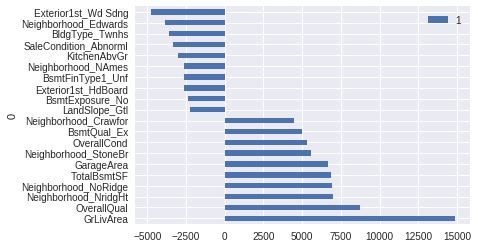

In [61]:
#using top perfomring model based on RMSE. 

print(cv_results_df.loc[63, 'model'])
plot_coef(cv_results_df.loc[63, 'model'])

#### Which features add / take away most value from a home?

* `LivingArea` and `OverallQual` are the largest drivers of price
* `SaleCondition_Partial` is the greatest detractor of house price. This as unsurprising as it suggest that significant work will be required to make the house livable.

# (Optional) Informing Business Value

Interpreting our work for a non-technical audience is a vital skill that every good Data Scientist must cultivate.  At the end of the day, our work must be informative to business process so connecting our detailed efforts to a high level strategy is critical.

We've established a few businesses cases that you should assert some explanation and advise best strategy through a model of your choice.  Also call out any exploratory analysis and reasoning for any recommendation.

##### For each question:
* Plot relevant data
* Fit a new model or use a previous  model
* Plot relevant coefficients


#### (Optional) Case 1: Which features add / take away most value from a home?

You just explained which coeffients add / take away most value, technically, but can you explain this in a non-technical manner?  Also, emphasize _why_ in your explanation.

- Choose a few examples and explain why the coefficients describe the target value of the property.

**Overall Quality** 

Consider the home buying experience. You are driving to meet your realtor at yet another house. You turn the corner and see your realtor getting out of their car in front of a house. Close your eyes. What do you want that house to look like? Are you excited, or has your stomach dropped? 

Home buying is an emotional experience, and a house can either capture or turn away prospective buyers before they get out of their car. You want to stoke the perspectives excitement and draw them to the front door. As the  buyer steps over the threshold they need to be able to visualize themselves and their family in that house. Do not break this spell, as it is what makes a house a home; every stained carpet or paint flake or crack in the foundation tarnishes the buyers vision of the house and pushes them to drive to the next house.



#### (Optional) Case 2: Can you identify any abnormally priced houses?
We might consider these being properties that are over or under predicted by price. Can you make sense of when and why these are over and under predicted?

In [ ]:
# looking at the total dataset
scaler = StandardScaler()
scaler.fit(X_train)
X_all = scaler.transform(X)

In [ ]:
y_pred = pd.Series(cv_results_df.loc[63, 'model'].predict(X_all))

In [ ]:
df_modeling['Id'].shape, y.shape, y_pred.shape

In [ ]:
y_df = pd.DataFrame({ 'Id': df_modeling['Id'],
                     'Actual': list(y), 
                     'Predicted': list(y_pred)})
y_df.shape

In [ ]:
y_df.set_index('Id', inplace=True)

In [ ]:
y_df['Residual'] = y_df['Actual'] - y_df['Predicted']

In [ ]:
y_df.sort_values('Residual').head(5)

In [ ]:
#start by looking at the houses where 
y_df.sort_values('Residual').tail(5)

In [ ]:
df_modeling[df_modeling['Id'].isin([524, 1325, 633, 582, 589,
                                   1182, 665, 775, 474, 689])].T

# the majority of the houses with the largest (absolute) residuals appear to have been built or 
# remodeled relatively recently

In [ ]:
fig = plt.figure(figsize=(20, 20))
plt.vlines(range(len(y_df)), ymin = y_df.sort_values('Actual')['Actual'], 
           ymax = y_df.sort_values('Actual')['Predicted'],
          alpha = 0.25)
plt.scatter(range(len(y_df)), y_df.sort_values('Actual')['Actual'])
plt.scatter(range(len(y_df)), y_df.sort_values('Actual')['Predicted'], marker = "v", c="r")

# plt.scatter(, y_pred.sort_values(), marker="v")

# plt.scatter(y_pred[y.index],)

#### (Optional) Case 3:  Which houses are good investments?

Which criteria would you look at?  How sure can you be of your assumptions?  Give precise metrics but also give a concise recommendation that is non-technical that communicates the risks of your anlaysis.

In [ ]:
# location location location
# 1. Identify the most expensive neighborhoods

temp_df = df_trim[['Neighborhood', 'SalePrice']]
temp_df.groupby('Neighborhood').mean().plot.bar()

#NoRidge, NridgHt, StoneBr appear to be the most expensive neighborhoods

In [ ]:
temp_df = df_trim.query("Neighborhood in ('NoRidge', 'NridgHt', 'StoneBr')")
opprotunity_ids = temp_df.sort_values('SalePrice')['Id'][0:10]
opprotunity_ids

In [ ]:

opprotunity_df = df_modeling[df_modeling['Id'].isin(opprotunity_ids)]

#### (Optional) Case 4:  Which houses are good investments (extended)?
One idea that is common in the real-estate invement community is called "flipping".  This usually entails buying a property with "changable" charactaristics that can be upgraded.  Examples of changable or "upgradable" features include:  A garage, a kitchen, etc.

Can you give us an idea of investments opportunities considering "upgradable" features?  You will have to explore this idea on your own and possibly do a little research for subject matter expertise.

- Some features of a house are worth more than others
- Some features can't be upgraded (ie: square footage)

In [ ]:
#adapt plot_coef function to return the coefs
def get_coef(model, top_n = 10):
    '''
    Returns the names top n coefficients
    '''
    cols = X_train.columns
    coef = model.coef_
    zipped = list(zip(cols, coef))
    zipped.sort(key=lambda x: x[1], reverse = True)
    top_10 = pd.DataFrame(zipped).head(top_n)
#     bottom_10 = pd.DataFrame(zipped).tail(top_n)
    return list(top_10[0])

In [ ]:
top_coefs = get_coef(cv_results_df.loc[63, 'model'], 50)
opprotunity_df[top_coefs].T

Most of these homes have not been renovated/remodeled since they were constructed. A Renovation would likely increase the homes value. 